[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Loaded IMDB (sample) dataset: (50000, 2)
Train size: (40000,) Val size: (10000,)
Training the TF-IDF + LogisticRegression model... (this may take 1-2 min)
Training complete
Accuracy: 0.8977
ROC AUC: 0.9621267199999999

Classification report:
               precision    recall  f1-score   support

           0     0.9059    0.8876    0.8967      5000
           1     0.8898    0.9078    0.8987      5000

    accuracy                         0.8977     10000
   macro avg     0.8979    0.8977    0.8977     10000
weighted avg     0.8979    0.8977    0.8977     10000



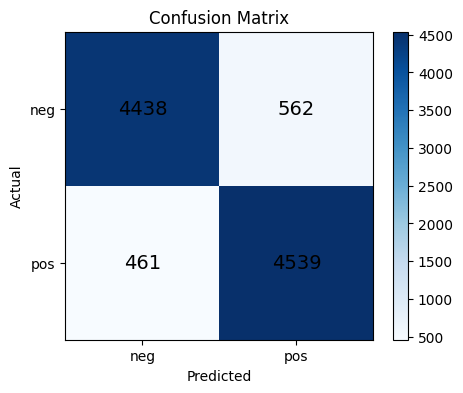

Saved model as sentiment_pipeline.joblib (you can download from left pane or mount Drive).
I absolutely loved this movie — fantastic acting and story! -> {'label': 'positive', 'confidence': 0.9523317871255025}
This was the worst purchase I have ever made. Do not recommend. -> {'label': 'negative', 'confidence': 0.9083990619721805}


,text,pred
0,understand anytime someone show one largest me...,0
1,playing kaddiddlehopper col san fernando etc m...,1
2,traveling train woman st phane excoffier mista...,0
3,know farmers spray fields right manure bbc dec...,0
4,old axiom bored people boring people well demo...,0


In [1]:
# ---------------------------
# 0) Install required libs
# ---------------------------
!pip install -q datasets nltk

# Optional / heavy (only if you want to fine-tune BERT later)
# !pip install -q transformers accelerate evaluate

# ---------------------------
# 1) Imports and helper setup
# ---------------------------
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

import joblib

# NLTK stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

# ---------------------------
# 2) Load data - Option A: use IMDB dataset (sample, ready to run)
# ---------------------------
from datasets import load_dataset
ds = load_dataset("imdb")
df_train = ds['train'].to_pandas()[['text','label']]
df_test  = ds['test'].to_pandas()[['text','label']]
df = pd.concat([df_train, df_test], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
print("Loaded IMDB (sample) dataset:", df.shape)
df.head()

# ---------------------------
# 2b) OR Option B: Use your own CSV
# If you want to use your own CSV, uncomment the block below and upload your file in Colab.
# The CSV must have columns 'text' and 'label' (label as 0/1 or 'positive'/'negative').
# ---------------------------
'''
# from google.colab import files
# uploaded = files.upload()  # browse & upload your CSV
# fname = list(uploaded.keys())[0]
# df = pd.read_csv(fname)
# print("Your dataset loaded:", df.shape)
# # Ensure columns names:
# # if labels are 'positive'/'negative', convert to 1/0:
# if df['label'].dtype == object:
#     df['label'] = df['label'].map(lambda x: 1 if str(x).lower().startswith('pos') else 0)
# df = df[['text','label']].dropna().reset_index(drop=True)
# df.head()
'''

# ---------------------------
# 3) Simple preprocessing
# ---------------------------
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', ' ', text)          # remove URLs
    text = re.sub(r'[^a-z0-9\s]', ' ', text)      # remove punctuation
    tokens = [w for w in text.split() if w not in stop and len(w) > 1]
    return " ".join(tokens)

# Apply preprocessing (this may take a minute)
df['clean_text'] = df['text'].astype(str).apply(preprocess)
df[['clean_text','label']].head()

# ---------------------------
# 4) Train / Validation split
# ---------------------------
X = df['clean_text']
y = df['label'].astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train size:", X_train.shape, "Val size:", X_val.shape)

# ---------------------------
# 5) Build pipeline: TF-IDF + Logistic Regression
# ---------------------------
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000))
])

print("Training the TF-IDF + LogisticRegression model... (this may take 1-2 min)")
pipeline.fit(X_train, y_train)
print("Training complete")

# ---------------------------
# 6) Evaluate
# ---------------------------
y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:,1]

print("Accuracy:", accuracy_score(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_proba))
print("\nClassification report:\n", classification_report(y_val, y_pred, digits=4))

# Confusion matrix plot
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0,1], ['neg','pos'])
plt.yticks([0,1], ['neg','pos'])
for (i,j),val in np.ndenumerate(cm):
    plt.text(j, i, str(val), ha='center', va='center', color='black', fontsize=14)
plt.title("Confusion Matrix")
plt.show()

# ---------------------------
# 7) Save model (download or save to Drive)
# ---------------------------
joblib.dump(pipeline, "sentiment_pipeline.joblib")
print("Saved model as sentiment_pipeline.joblib (you can download from left pane or mount Drive).")

# If you want to auto-download in Colab to your local machine:
#from google.colab import files
#files.download("sentiment_pipeline.joblib")

# ---------------------------
# 8) Quick prediction function
# ---------------------------
def predict_text(text):
    cleaned = preprocess(text)
    pred = pipeline.predict([cleaned])[0]
    prob = pipeline.predict_proba([cleaned])[0].max()
    label = "positive" if pred == 1 else "negative"
    return {"label": label, "confidence": float(prob)}

# Try some examples:
examples = [
    "I absolutely loved this movie — fantastic acting and story!",
    "This was the worst purchase I have ever made. Do not recommend."
]
for ex in examples:
    print(ex, "->", predict_text(ex))

# ---------------------------
# 9) Optional: small sample predictions saved to CSV for submission/demo
# ---------------------------
sample_preds = pd.DataFrame({
    "text": X_val.sample(20, random_state=42).values,
    "pred": pipeline.predict(X_val.sample(20, random_state=42))
})
sample_preds.head()
